In [1]:
import os
from PIL import Image, ImageFile
import math
import copy
ImageFile.LOAD_TRUNCATED_IMAGES = True
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Admin\.virtualenvs\AR_classification-AOelGpcL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import open_clip

model_name = 'coca_ViT-L-14' #'ViT-L-14-CLIPA'
pretrained = 'mscoco_finetuned_laion2b_s13b_b90k' #'datacomp1b'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                             device = device,
                                                             pretrained=pretrained)

In [3]:
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x000001BFED44A440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [4]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [5]:
base_dir = './dataset/'
src_dir = base_dir + '/test_tran'
query_dir = base_dir + '/queries'
submission = pd.read_csv(base_dir+ '/sample_submission.csv')

In [6]:

import os
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision.transforms import Resize, CenterCrop, Pad, Compose
import torchvision.transforms.functional as F


query_classes = []
q_batch =  []
print(preprocess)
# Define transforms for each augmentation
preprocess_original = preprocess  # Your original preprocess function for clear RGB images
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess
])
preprocess_blur = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    preprocess
])
preprocess_zoom_out = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    # Step 1: Resize the image to make it smaller than the model's expected input dimensions
    transforms.Resize(180),  # Assuming the original input size is 256x256, adjust this value as needed
    # Step 2: Pad the resized image to match the model's expected input dimensions
    # The padding mode can be changed as needed (e.g., 'constant', 'edge', 'reflect')
    lambda img: F.pad(img, padding=(38, 38, 38, 38), padding_mode='constant', fill=0),
    # Step 3: Apply your model-specific preprocessing (e.g., normalization)
    preprocess
])
preprocess_sharpness = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(contrast=(1,2)),
    preprocess
])

preprocess_affine1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomAffine(degrees=(0, 90), scale=(0.5, 0.9)),
    preprocess
])

gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    ])

augmentations = {
    'rotation': transforms.Compose([transforms.RandomRotation(degrees=(0,90))]),
    'rotation2': transforms.Compose([transforms.RandomRotation(degrees=(270,360))]),
    'affine': transforms.Compose([ transforms.RandomAffine(degrees=(0, 90), scale=(0.5, 0.9))]),
    'affine2': transforms.Compose([ transforms.RandomAffine(degrees=(270, 360), scale=(0.5, 0.9))]),
    'sharpness': transforms.Compose([transforms.RandomAdjustSharpness(40)]),
    'contrast': transforms.Compose([transforms.ColorJitter(contrast=(1,2))]),
}


for file in os.listdir(query_dir):
    print(file)
    class_id = int(file[:-5])  # Assuming the class ID is in the filename
    count = 0    
    # Load image
    img_path = os.path.join(query_dir, file)
    image = Image.open(img_path).convert('RGB')
    # for augmentation_name, augmentation_transform in augmentations.items():
    #     combined_transform = transforms.Compose([gray,preprocess,augmentation_transform])
    #     print(combined_transform)
    #     q_batch.append(combined_transform(image))
    #     count += 1    
    # # Apply each augmentation and append to q_batch
    q_batch.append(preprocess_original(image))  # Original clear RGB image
    q_batch.append(preprocess_grayscale(image))  # Grayscale
    q_batch.append(preprocess_blur(image))  # Blurred
    q_batch.append(preprocess_zoom_out(image))
    #q_batch.append(preprocess_sharpness(image))#zoom-out
    #q_batch.append(preprocess_affine1(image))
    count = count + 4
    # Replicate class ID for each augmented image version
    query_classes.extend([class_id] * count)# 4 versions of each image
    print(query_classes)

# Stack all processed images into a tensor
q_batch_transformed = torch.stack(q_batch, dim=0).to(device)

print(q_batch_transformed.shape)  # Check the shape, should be 4x larger in the first dimension

# Generate embeddings
with torch.no_grad():
    q_embeddings = model.encode_image(q_batch_transformed).cpu()
    q_embeddings /= q_embeddings.norm(dim=-1, keepdim=True)
torch.save(model.state_dict(), 'openclip_test.pth')
print(q_embeddings.shape)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x000001BFED44A440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
1.jpeg
[1, 1, 1, 1]
2.jpeg
[1, 1, 1, 1, 2, 2, 2, 2]
3.jpeg
[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
torch.Size([12, 3, 224, 224])
torch.Size([12, 768])


tensor([[0.6435, 0.6538, 0.6401, 0.6433, 0.5560, 0.5821, 0.5750, 0.5397, 0.2541,
         0.2428, 0.2160, 0.2102]])
tensor([[0.0967, 0.0976, 0.0963, 0.0966, 0.0886, 0.0909, 0.0903, 0.0871, 0.0655,
         0.0647, 0.0630, 0.0627]])
tensor(0.0976)
tensor([0.6435, 0.6538, 0.6401, 0.6433, 0.5560, 0.5821, 0.5750, 0.5397, 0.2541,
        0.2428, 0.2160, 0.2102])
tensor(0.6538)


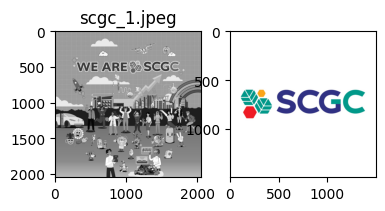

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          4      None             4                4
2    scgc_7.jpeg      1          4      None             4                4
3    scgc_9.jpeg      1          4      None             4                4
4    scgp_3.jpeg      2          4      None             4                4
5    scgp_4.jpeg      2          4      None             4                4
6    scgp_5.jpeg      2          4      None             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


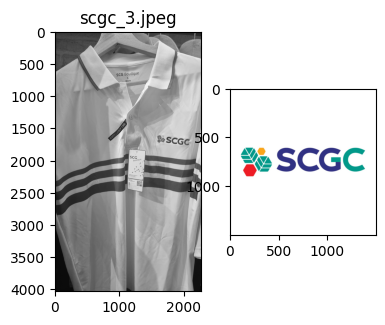

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          4      None             4                4
3    scgc_9.jpeg      1          4      None             4                4
4    scgp_3.jpeg      2          4      None             4                4
5    scgp_4.jpeg      2          4      None             4                4
6    scgp_5.jpeg      2          4      None             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


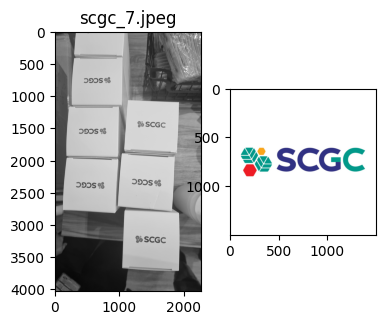

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          4      None             4                4
4    scgp_3.jpeg      2          4      None             4                4
5    scgp_4.jpeg      2          4      None             4                4
6    scgp_5.jpeg      2          4      None             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


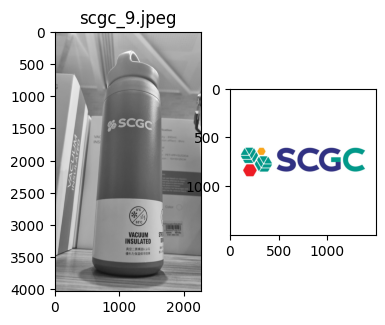

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          4      None             4                4
5    scgp_4.jpeg      2          4      None             4                4
6    scgp_5.jpeg      2          4      None             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


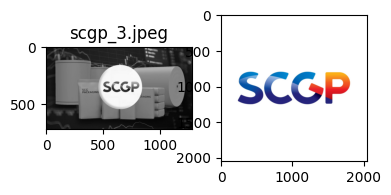

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          4      None             4                4
6    scgp_5.jpeg      2          4      None             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


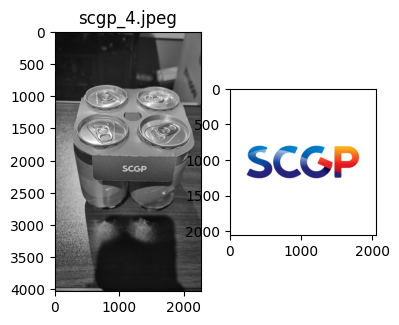

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          4      None             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


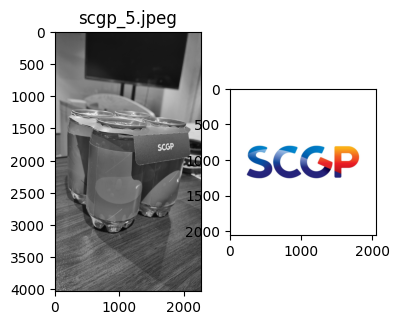

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          4      None             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.4194, 0.4373, 0.4219, 0.4437, 0.4758, 0.5370, 0.5314, 0.4942, 0.2585,
         0.2542, 0.2300, 0.2290]])
tensor([[0.0849, 0.0864, 0.0851, 0.0870, 0.0898, 0.0955, 0.0950, 0.0915, 0.0723,
         0.0720, 0.0703, 0.0702]])
tensor(0.0955)
tensor([0.4194, 0.4373, 0.4219, 0.4437, 0.4758, 0.5370, 0.5314, 0.4942, 0.2585,
        0.2542, 0.2300, 0.2290])
tensor(0.5370)


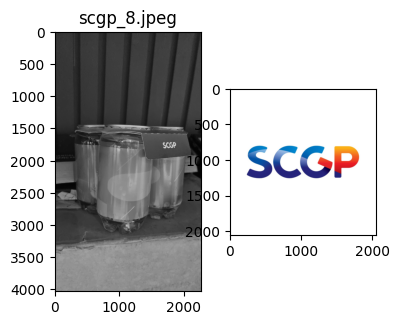

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


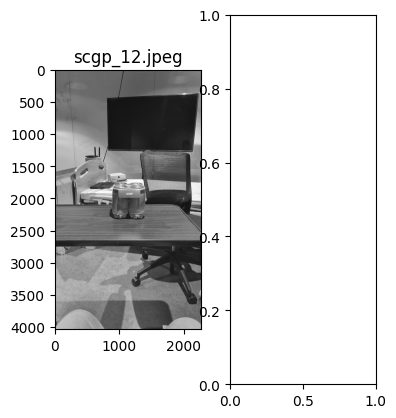

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          4      None             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


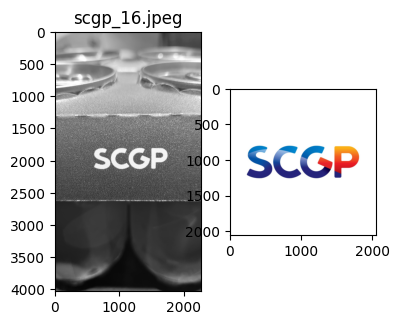

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          2      SCGP             4                4
10   wedo_3.jpeg      3          4      None             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


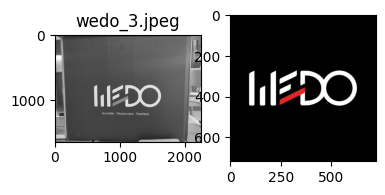

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          2      SCGP             4                4
10   wedo_3.jpeg      3          3      WEDO             4                4
11   wedo_9.jpeg      3          4      None             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


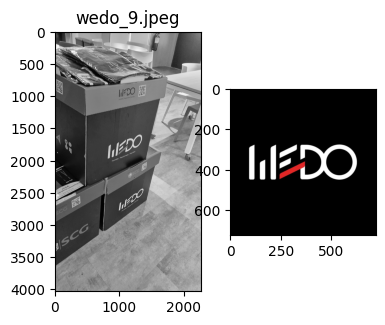

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          2      SCGP             4                4
10   wedo_3.jpeg      3          3      WEDO             4                4
11   wedo_9.jpeg      3          3      WEDO             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


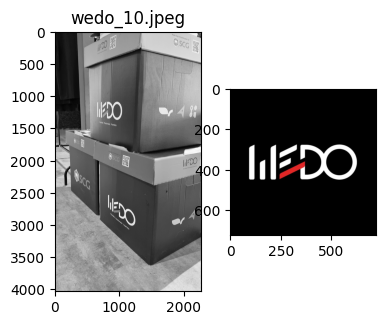

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          2      SCGP             4                4
10   wedo_3.jpeg      3          3      WEDO             4                4
11   wedo_9.jpeg      3          3      WEDO             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


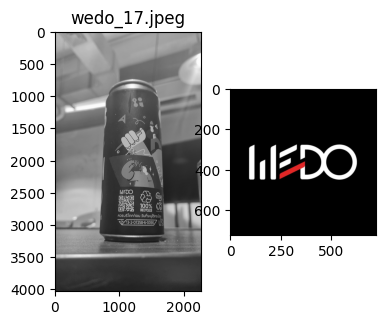

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          2      SCGP             4                4
10   wedo_3.jpeg      3          3      WEDO             4                4
11   wedo_9.jpeg      3          3      WEDO             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


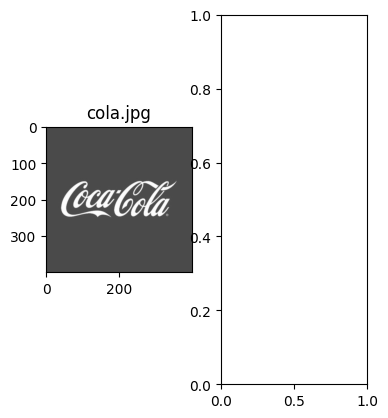

        img_file  class  dot_class Predicted  cosine_class  minkowski_class
0    scgc_1.jpeg      1          1      SCGC             4                4
1    scgc_3.jpeg      1          1      SCGC             4                4
2    scgc_7.jpeg      1          1      SCGC             4                4
3    scgc_9.jpeg      1          1      SCGC             4                4
4    scgp_3.jpeg      2          2      SCGP             4                4
5    scgp_4.jpeg      2          2      SCGP             4                4
6    scgp_5.jpeg      2          2      SCGP             4                4
7    scgp_8.jpeg      2          2      SCGP             4                4
8   scgp_12.jpeg      2          4      None             4                4
9   scgp_16.jpeg      2          2      SCGP             4                4
10   wedo_3.jpeg      3          3      WEDO             4                4
11   wedo_9.jpeg      3          3      WEDO             4                4
12  wedo_10.

C:\Users\Admin\AppData\Local\Temp\ipykernel_21812\3031054361.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


In [7]:
# test images
submission['dot_class'] = 4
submission['cosine_class'] = 4
submission['minkowski_class'] = 4
submission['Predicted'] = 'None'
label ={1:'SCGC', 2:'SCGP',3:'WEDO'}
with torch.no_grad():
    for idx, row in submission.iterrows():
        #print(row)
        # image = Image.open(os.path.join(src_dir, row['img_file'])).convert('RGB')
        # to grayscale
        image = Image.open(os.path.join(src_dir, row['img_file'])).convert('L')  # Convert to grayscale
        image = image.convert('RGB')  # Convert back to RGB by replicating channels

        # embedding
        inputs = preprocess(image).to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model.encode_image(inputs).cpu()
        outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        #print(outputs.softmax(1))
        # compute similarity with query
        #print(outputs.shape, q_embeddings.T.shape)
        values = outputs @ q_embeddings.T
        #values = outputs @ q_embeddings.T
        print(values)
        print(values.softmax(1))
        print(values.softmax(1).max())
        thre_dot = 0.09 
        if values.softmax(1).max() > thre_dot:
            dot_class = query_classes[values.argmax().numpy().tolist()]
            submission.at[idx, 'dot_class'] = dot_class
            submission.at[idx, 'Predicted'] = label[dot_class]
        else:
            dot_class = 4

        cosine = torch.cosine_similarity(outputs, q_embeddings)
        print(cosine)
        print(cosine.max())
        # thre_cosine = 0.5 #0.8
        # if cosine.max() > thre_cosine:  #0.8
        #     cosine_class = query_classes[cosine.argmax().numpy().tolist()]
        #     submission.at[idx, 'cosine_class'] = cosine_class
        # else:
        #     cosine_class = 4

        # # display result for 50 images
        if 0 <= idx < 50:
            plt.subplot(1,3,1)
            plt.title(row['img_file'])
            plt.imshow(image)
            plt.subplot(1,3,2)
            if dot_class != 4:
                plt.imshow(Image.open(os.path.join(query_dir, str(dot_class) + '.jpeg')))
            #plt.subplot(1,3,3)
            # if cosine_class != 4:
            #     plt.imshow(Image.open(os.path.join(query_dir, str(cosine_class) + '.jpeg')))
            plt.show()

        sub = submission[['img_file',]]
    #     sub['class'] = submission['dot_class']
    #     sub.to_csv(root + model_name + '-' + pretrained + '_dot_product_than'+ str(thre_dot).replace('.', '-') +'-aug04.csv', index=False)
        print(submission)
        sub['class'] = submission['Predicted']
        sub.to_csv('for_submission.csv', index=False)
